In [4]:
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.patches as patches
import matplotlib.lines as lines
import numpy as np
from six.moves import cPickle as pickle
import json
from tqdm import tqdm

In [5]:
# VG
dir_path = 'Outputs/vg_X-101-64x4d-FPN/'

In [7]:
topk_dets_file = os.path.join(dir_path, 'rel_detections_topk.pkl')
with open(topk_dets_file, 'rb') as f:
    topk_dets = pickle.load(f)

In [8]:
print(len(topk_dets))
print(topk_dets[0].keys())
print(topk_dets[0]['det_boxes_o_top'].shape)
print(topk_dets[0]['det_scores_top'].shape)
min_len = 100
for det in topk_dets:
    if min_len > det['det_scores_top'].shape[0]:
        min_len = det['det_scores_top'].shape[0]
print(min_len)

26446
dict_keys(['image', 'det_boxes_s_top', 'det_boxes_o_top', 'det_labels_s_top', 'det_labels_p_top', 'det_labels_o_top', 'det_scores_top', 'gt_boxes_sbj', 'gt_boxes_obj', 'gt_labels_sbj', 'gt_labels_obj', 'gt_labels_prd'])
(100, 4)
(100,)
100


In [13]:
# VG
img_path = 'data/vg/VG_100K/'
with open('data/vg/objects.json') as f:
    obj_cats = json.load(f)
with open('data/vg/predicates.json') as f:
    prd_cats = json.load(f)

In [14]:
def box_overlap(box1, box2):
    overlap = 0.0
    box_area = (
        (box2[2] - box2[0] + 1) *
        (box2[3] - box2[1] + 1)
    )
    iw = (
        min(box1[2], box2[2]) -
        max(box1[0], box2[0]) + 1
    )
    if iw > 0:
        ih = (
            min(box1[3], box2[3]) -
            max(box1[1], box2[1]) + 1
        )
        if ih > 0:
            ua = float(
                (box1[2] - box1[0] + 1) *
                (box1[3] - box1[1] + 1) +
                box_area - iw * ih
            )
            overlap = iw * ih / ua
    return overlap

# box1 and box2 are in [x1, y1. w. h] format
def box_union(box1, box2):
    xmin = min(box1[0], box2[0])
    ymin = min(box1[1], box2[1])
    xmax = max(box1[0] + box1[2] - 1, box2[0] + box2[2] - 1)
    ymax = max(box1[1] + box1[3] - 1, box2[1] + box2[3] - 1)
    return [xmin, ymin, xmax - xmin + 1, ymax - ymin + 1]

def box2rect(img, box):
    x = box[0] + edge_width / 2
    y = box[1] + edge_width / 2
    w = box[2] - box[0] - edge_width
    h = box[3] - box[1] - edge_width
    return x, y, w, h

ind:  6032
image:  2322669.jpg
topk:  50
sbj_labels.shape[0]:  100


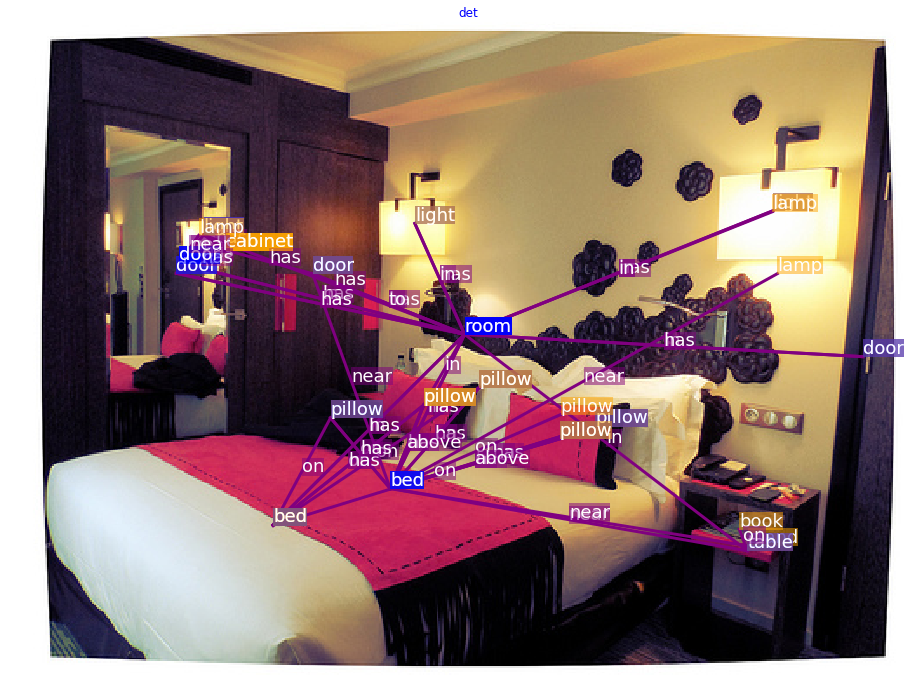

0: pillow on bed
		total score:	 0.594369
1: pillow on bed
		total score:	 0.562636
2: bed in room
		total score:	 0.519050
3: bed in room
		total score:	 0.417869
4: pillow on bed
		total score:	 0.385909
5: bed has pillow
		total score:	 0.350772
6: bed has pillow
		total score:	 0.329609
7: pillow on bed
		total score:	 0.319940
8: room has bed
		total score:	 0.301991
9: pillow on bed
		total score:	 0.298278
10: door in room
		total score:	 0.271658
11: room has light
		total score:	 0.254051
12: door in room
		total score:	 0.252159
13: pillow on bed
		total score:	 0.250924
14: pillow on bed
		total score:	 0.237545
15: room has door
		total score:	 0.235191
16: room has bed
		total score:	 0.234738
17: table near bed
		total score:	 0.228227
18: room has door
		total score:	 0.226604
19: bed has pillow
		total score:	 0.216487
20: door in room
		total score:	 0.209928
21: room has door
		total score:	 0.199067
22: bed has pillow
		total score:	 0.193803
23: room has light
		tot

In [18]:
edge_width = 3
font_size = 18
topk = 50  # 100
score_thr = 0.0  # 0.05

save_output = False

ind = np.random.randint(0, len(topk_dets))
print('ind: ', ind)
det = topk_dets[ind]

sbj_boxes = det['det_boxes_s_top']
sbj_labels = det['det_labels_s_top']
obj_boxes = det['det_boxes_o_top']
obj_labels = det['det_labels_o_top']
prd_labels = det['det_labels_p_top']
det_scores = det['det_scores_top']

img_name = det['image'].split('/')[-1]
print('image: ', img_name)
print('topk: ', topk)
print('sbj_labels.shape[0]: ', sbj_labels.shape[0])

img = mpimg.imread(img_path + img_name)

fig = plt.figure(figsize=(18, 12))
ax = plt.gca()
plt.imshow(img)
plt.axis('off')
det_title = plt.title('det')
plt.setp(det_title, color='b')
for j in range(min(topk, sbj_labels.shape[0])):
    # det
    det_score = det_scores[j]
    if det_score < score_thr:
        continue
    sbj_label = sbj_labels[j]
    obj_label = obj_labels[j]
    prd_label = prd_labels[j]
    sbj_box = sbj_boxes[j]
    obj_box = obj_boxes[j]
    s_name = obj_cats[sbj_label]
    o_name = obj_cats[obj_label]
    p_name = prd_cats[prd_label]
    
    s_x, s_y, s_w, s_h = box2rect(img, sbj_box)
    s_cx = s_x + s_w // 2
    s_cy = s_y + s_h // 2
    ax.text(s_cx, s_cy - 2,
            s_name,
            fontsize=font_size,
            color='white',
            bbox=dict(facecolor='orange', alpha=0.5, pad=0, edgecolor='none'))
    
    o_x, o_y, o_w, o_h = box2rect(img, obj_box)
    o_cx = o_x + o_w // 2
    o_cy = o_y + o_h // 2
    ax.text(o_cx, o_cy - 2,
            o_name,
            fontsize=font_size,
            color='white',
            bbox=dict(facecolor='blue', alpha=0.5, pad=0, edgecolor='none'))
    
    rel_l = lines.Line2D([s_cx, o_cx], [s_cy, o_cy], color='purple', linewidth=edge_width)
    ax.add_line(rel_l)
    ax.text((s_cx + o_cx) / 2, (s_cy + o_cy) / 2,
            p_name,
            fontsize=font_size,
            color='white',
            bbox=dict(facecolor='purple', alpha=0.5, pad=0, edgecolor='none'))

if save_output:
    output_dir = os.path.join(dir_path, img_id)
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    plt.savefig(os.path.join(output_dir, 'all_true_pos.jpg'), bbox_inches='tight')
plt.show()
plt.close(fig)

# print names and scores
for j in range(min(topk, sbj_labels.shape[0])):
    # det
    det_score = det_scores[j]
    if det_score < score_thr:
        continue
    sbj_label = sbj_labels[j]
    obj_label = obj_labels[j]
    prd_label = prd_labels[j]
    s_name = obj_cats[sbj_label]
    o_name = obj_cats[obj_label]
    p_name = prd_cats[prd_label]
    print('{}: {} {} {}'.format(j, s_name, p_name, o_name))
    print('\t\ttotal score:\t {:.6f}'.format(det_score))